In [1]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion


# Use finite difference hessian for stepping.

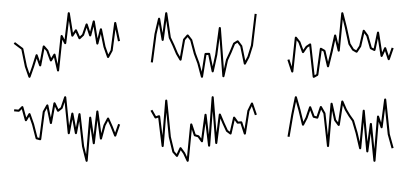

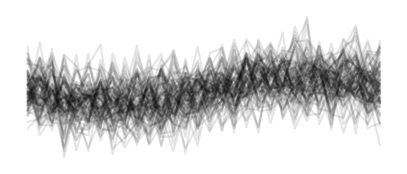

<Figure size 640x480 with 0 Axes>

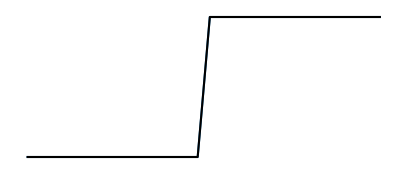

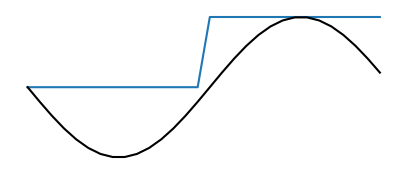

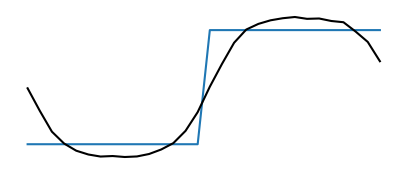

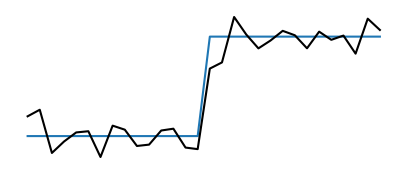

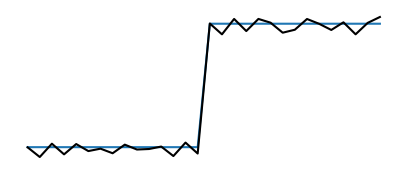

In [7]:
def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

L = 31
t = jnp.linspace(0, 2*jnp.pi, L)[:-1]
f = lambda t: jnp.where(t>=jnp.pi, 1., 0.)
x = f(t)
xfft = fft(x)

sigma = 1.
y, noise, shift = get_samples(jax.random.PRNGKey(0), x, sigma, 20000)
mean, acf, _ = invariants_from_data(y, sigma)
yfft = fft(y)



z0 = jnp.sin(1*t)
z0fft = fft(z0)
zfft = align_average(z0fft, yfft)
z1fft = project_moments(zfft, acf, mean)
zufft = zfft


z = ifft(zfft).real
z1 = ifft(z1fft).real
zu = ifft(project_moments(zufft, acf, mean)).real

g = 1.0
for i in range(200):
    zufft = align_average(zufft, yfft)
    zfft = (1-g) * z1fft + g * align_average(z1fft, yfft)
    z1fft = project_moments(zfft, acf, mean)

zu = ifft(project_moments(z1fft, acf, mean)).real

def error(z):
    return jnp.linalg.norm(z-x)/jnp.linalg.norm(x)

data = [x, z0, z, z1, zu]
labels = ["true", "init", "align", "project", "final"]


plt.figure(figsize=(5,2))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(t, y[i], color="black")
    plt.axis("off")
plt.gcf().savefig("data.pdf", bbox_inches='tight')
    
plt.figure(figsize=(5,2))
for i in range(100):
    plt.plot(fft(align_fft(z0fft, yfft[i])).real, color='black', alpha=0.1)
    plt.axis("off")
    #plt.ylim([-40, 90])
    

plt.gcf().savefig("aligned_data.pdf", bbox_inches='tight')

plt.figure()
printout=""
for i in range(len(data)):
    plt.figure(figsize=(5,2))
    data[i] = ifft(align_fft(xfft, fft(data[i]))).real
    plt.plot(data[0])
    plt.plot(data[i], label=labels[i], color='black')
    printout += f"{labels[i]}: {error(data[i])}\n"
    plt.axis("off")
    plt.gcf().savefig(f"{labels[i]}.pdf", bbox_inches='tight')
#plt.legend()
#print(printout)

